## Business problem

#### Stakeholder: NASA

- 

#### True business problem:  

- 

#### Deliverables: Inference or Prediction?

- 

#### Context:

- **False negative** 
    - **Outcome**: 
- **False positive** 
    - **Outcome**: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../../data/UsableData.csv")
holdoutdf = pd.read_csv("../../data/UntestableData.csv")
df = df.drop(columns='Unnamed: 0')
df['HvarType'] = df['HvarType'].mask(df['HvarType'] != 'C', other='V')

mask = {
    'C': 0,
    'V': 1
}
df['Target'] = df['HvarType'].map(mask)

x = df.drop(columns=['HvarType','Target'])
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=42)

In [4]:
y_train.value_counts(normalize=True)

0    0.650421
1    0.349579
Name: Target, dtype: float64

Guessing not variable every time would be correct 65% of the time.

In [5]:
numCols = [col for col in x_train.columns if x_train[col].dtype != 'O']
numCols

['HIP',
 'Vmag',
 'VarFlag',
 'RAdeg',
 'DEdeg',
 'Plx',
 'pmRA',
 'pmDE',
 'e_RAdeg',
 'e_DEdeg',
 'e_Plx',
 'e_pmRA',
 'e_pmDE',
 'DE:RA',
 'Plx:RA',
 'Plx:DE',
 'pmRA:RA',
 'pmRA:DE',
 'pmRA:Plx',
 'pmDE:RA',
 'pmDE:DE',
 'pmDE:Plx',
 'pmDE:pmRA',
 'F1',
 'F2',
 '---',
 'BTmag',
 'e_BTmag',
 'VTmag',
 'e_VTmag',
 'B-V',
 'e_B-V',
 'V-I',
 'e_V-I',
 'Hpmag',
 'e_Hpmag',
 'Hpscat',
 'o_Hpmag',
 'Hpmax',
 'HPmin',
 'Period',
 'moreVar',
 'Nsys',
 'Ncomp',
 'theta',
 'rho',
 'e_rho',
 'dHp',
 'e_dHp',
 'HD',
 '(V-I)red']

In [6]:
x_train[numCols].isna().sum()

HIP              0
Vmag             0
VarFlag      45034
RAdeg          165
DEdeg          165
Plx            165
pmRA           165
pmDE           165
e_RAdeg        165
e_DEdeg        165
e_Plx          165
e_pmRA         165
e_pmDE         165
DE:RA          165
Plx:RA         165
Plx:DE         165
pmRA:RA        165
pmRA:DE        165
pmRA:Plx       165
pmDE:RA        165
pmDE:DE        165
pmDE:Plx       165
pmDE:pmRA      165
F1             165
F2             858
---              0
BTmag         1376
e_BTmag       1376
VTmag         1348
e_VTmag       1348
B-V            689
e_B-V          689
V-I            689
e_V-I          689
Hpmag            1
e_Hpmag          1
Hpscat         707
o_Hpmag        707
Hpmax          707
HPmin          707
Period       51831
moreVar      47530
Nsys         41951
Ncomp          165
theta        46366
rho          46366
e_rho        46366
dHp          46366
e_dHp        46366
HD            8717
(V-I)red         0
dtype: int64

### Simple Models, model each numeric variable with a logistic regression:

In [3]:
preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

Run a simple model for each numeric column and print metrics for it. If those metrics are all above 0, then add that column to a list to be used later.

In [8]:
len(numCols)

51

In [9]:
used_num_cols = []
for col in numCols:
    lg = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model',LogisticRegression(max_iter=5000, random_state=42))
    ])
    lg.fit(x_train[[col]], y_train)
    
    train_preds = lg.predict(x_train[[col]])
    test_preds = lg.predict(x_test[[col]])
    train_probs = lg.predict_proba(x_train[[col]])[:,1]
    test_probs = lg.predict_proba(x_test[[col]])[:,1]
    
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    train_recall = recall_score(y_train, train_preds, zero_division=0)
    test_recall = recall_score(y_test, test_preds, zero_division=0)
    train_precision = precision_score(y_train, train_preds, zero_division=0)
    test_precision = precision_score(y_test, test_preds, zero_division=0)
    train_f1 = f1_score(y_train, train_preds, zero_division=0)
    test_f1 = f1_score(y_test, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(y_train, train_probs)
    test_rocauc = roc_auc_score(y_test, test_probs)
    
    print(col)
    if (train_accuracy > 0) and (test_accuracy > 0) and (train_recall > 0) and (test_recall > 0) and (train_precision > 0) and (test_precision > 0) and (train_f1 > 0) and (test_f1 > 0) and (train_rocauc > 0) and (test_rocauc > 0):
        used_num_cols.append(col)
        print(f'{col} added to used column list')
    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    print("\nTrain Matrix:\n")
    print(confusion_matrix(y_train, train_preds))
    print("\nTest Matrix:\n")
    print(confusion_matrix(y_test, test_preds))
    print('\n')
    print("****"*20)
    print('\n')

HIP

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.49096253710321636
Test ROC-AUC:		0.49019535851846385

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


Vmag
Vmag added to used column list

Train Accuracy:		0.6512770869014819
Test Accuracy:		0.6497263487099296

Train Recall:		0.0025029289594205987
Test Recall:		0.003178639542275906

Train Precision:	0.9791666666666666
Test Precision:		1.0

Train f1:		0.004993094656326358
Test f1:		0.0063371356147021544

Train ROC-AUC:		0.5400225289000143
Test ROC-AUC:		0.5422443083631775

Train Matrix:

[[34937     1]
 [18731    47]]

Test Matrix:

[[11614     0]
 [ 6272    20]]


********************************************************************************


VarFlag
Var

pmRA:DE

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.504168333648942
Test ROC-AUC:		0.5049197411305447

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


pmRA:Plx

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Train Precision:	0.0
Test Precision:		0.0

Train f1:		0.0
Test f1:		0.0

Train ROC-AUC:		0.506560926108621
Test ROC-AUC:		0.4997325292785709

Train Matrix:

[[34938     0]
 [18778     0]]

Test Matrix:

[[11614     0]
 [ 6292     0]]


********************************************************************************


pmDE:RA

Train Accuracy:		0.6504207312532578
Test Accuracy:		0.6486094046688261

Train Recall:		0.0
Test Recall:		0.0

Trai

Hpmag
Hpmag added to used column list

Train Accuracy:		0.6524871546652766
Test Accuracy:		0.650787445548978

Train Recall:		0.006390456917669613
Test Recall:		0.006357279084551812

Train Precision:	0.9302325581395349
Test Precision:		0.975609756097561

Train f1:		0.01269371132384831
Test f1:		0.012632243802305383

Train ROC-AUC:		0.5471327566484631
Test ROC-AUC:		0.5489584864858829

Train Matrix:

[[34929     9]
 [18658   120]]

Test Matrix:

[[11613     1]
 [ 6252    40]]


********************************************************************************


e_Hpmag
e_Hpmag added to used column list

Train Accuracy:		0.6827388487601459
Test Accuracy:		0.6813358650731598

Train Recall:		0.0925551176909149
Test Recall:		0.09345200254291164

Train Precision:	0.9988505747126437
Test Precision:		0.9966101694915255

Train f1:		0.16941222341358805
Test f1:		0.1708805579773322

Train ROC-AUC:		0.6707624275605396
Test ROC-AUC:		0.6723953999332853

Train Matrix:

[[34936     2]
 [17040  1738]]

T

(V-I)red
(V-I)red added to used column list

Train Accuracy:		0.6904460495941619
Test Accuracy:		0.6897687925834916

Train Recall:		0.11950154436042178
Test Recall:		0.12285441830896376

Train Precision:	0.9597946963216424
Test Precision:		0.9555006180469716

Train f1:		0.2125402538359538
Test f1:		0.2177158146739896

Train ROC-AUC:		0.5266268946781988
Test ROC-AUC:		0.5299715821852115

Train Matrix:

[[34844    94]
 [16534  2244]]

Test Matrix:

[[11578    36]
 [ 5519   773]]


********************************************************************************




### Sink model, using all of the numeric columns that have all metrics above 0

In [10]:
len(used_num_cols)

32

In [4]:
used_num_cols1 = [
    'Vmag',
    'e_RAdeg',
    'e_DEdeg',
    'e_Plx',
    'e_pmRA',
    'e_pmDE',
    'Plx:DE',
    'F1',
    'F2',
    'BTmag',
    'e_BTmag',
    'VTmag',
    'B-V',
    'e_B-V',
    'V-I',
    'e_V-I',
    'Hpmag',
    'e_Hpmag',
    'Hpscat',
    'o_Hpmag',
    'Hpmax',
    'HPmin',
    'Ncomp',
    '(V-I)red']


Train Accuracy:		0.890814654851441
Test Accuracy:		0.8905953311739082

Train Recall:		0.739109596336138
Test Recall:		0.7418944691671965

Train Precision:	0.9349275850454698
Test Precision:		0.9330401758944633

Train f1:		0.8255658329119948
Test f1:		0.8265604249667995

Train ROC-AUC:		0.9231157030775957
Test ROC-AUC:		0.9262285630677227


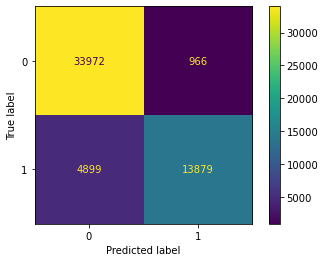

In [5]:
# sink_model = Pipeline(steps=[
#     ('preprocessor',preprocessor),
#     ('logreg', LogisticRegression(max_iter=5000, random_state=42))
# ])

# sink_model.fit(x_train[used_num_cols1], y_train)

# train_preds = sink_model.predict(x_train[used_num_cols1])
# test_preds = sink_model.predict(x_test[used_num_cols1])
# train_probs = sink_model.predict_proba(x_train[used_num_cols1])[:,1]
# test_probs = sink_model.predict_proba(x_test[used_num_cols1])[:,1]
    
# train_accuracy = accuracy_score(y_train, train_preds)
# test_accuracy = accuracy_score(y_test, test_preds)
# train_recall = recall_score(y_train, train_preds, zero_division=0)
# test_recall = recall_score(y_test, test_preds, zero_division=0)
# train_precision = precision_score(y_train, train_preds, zero_division=0)
# test_precision = precision_score(y_test, test_preds, zero_division=0)
# train_f1 = f1_score(y_train, train_preds, zero_division=0)
# test_f1 = f1_score(y_test, test_preds, zero_division=0)
# train_rocauc = roc_auc_score(y_train, train_probs)
# test_rocauc = roc_auc_score(y_test, test_probs)

# print(F'\nTrain Accuracy:\t\t{train_accuracy}')
# print(F'Test Accuracy:\t\t{test_accuracy}')
# print(F"\nTrain Recall:\t\t{train_recall}")
# print(F'Test Recall:\t\t{test_recall}')
# print(F"\nTrain Precision:\t{train_precision}")
# print(F'Test Precision:\t\t{test_precision}')
# print(F"\nTrain f1:\t\t{train_f1}")
# print(F'Test f1:\t\t{test_f1}')
# print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
# print(F'Test ROC-AUC:\t\t{test_rocauc}')



0.9215317768435197
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('tree',
                 DecisionTreeClassifier(max_depth=15, min_samples_split=74,
                                        random_state=42))])

Train Accuracy:		0.9379328319308958
Test Accuracy:		0.9246621244275662

Train Recall:		0.8762381510277985
Test Recall:		0.8606166560712015

Train Precision:	0.9421667430142007
Test Precision:		0.9198233395617462

Train f1:		0.9080072843662049
Test f1:		0.8892355694227769

Train ROC-AUC:		0.9622886159321064
Test ROC-AUC:		0.9450699188486262


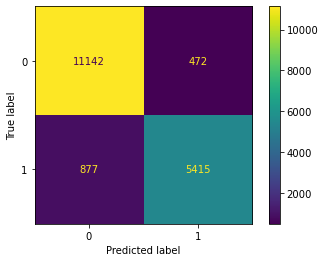

In [7]:
# tree = Pipeline(steps=[
#     ('preprocessor',preprocessor),
#     ('tree', DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=74))
# ])

# # tree.fit(x_train[used_num_cols1], y_train)
# param_grid = {
#     "tree__max_depth" : [15],
#     "tree__min_samples_split" : [74],
# }
# cv_rfc = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5)
# cv_rfc.fit(x_train[used_num_cols1], y_train)

# print(cv_rfc.best_score_)

# estimator = cv_rfc.best_estimator_
# print(estimator)

# train_preds = estimator.predict(x_train[used_num_cols1])
# test_preds = estimator.predict(x_test[used_num_cols1])
# train_probs = estimator.predict_proba(x_train[used_num_cols1])[:,1]
# test_probs = estimator.predict_proba(x_test[used_num_cols1])[:,1]
    
# train_accuracy = accuracy_score(y_train, train_preds)
# test_accuracy = accuracy_score(y_test, test_preds)
# train_recall = recall_score(y_train, train_preds, zero_division=0)
# test_recall = recall_score(y_test, test_preds, zero_division=0)
# train_precision = precision_score(y_train, train_preds, zero_division=0)
# test_precision = precision_score(y_test, test_preds, zero_division=0)
# train_f1 = f1_score(y_train, train_preds, zero_division=0)
# test_f1 = f1_score(y_test, test_preds, zero_division=0)
# train_rocauc = roc_auc_score(y_train, train_probs)
# test_rocauc = roc_auc_score(y_test, test_probs)

# print(F'\nTrain Accuracy:\t\t{train_accuracy}')
# print(F'Test Accuracy:\t\t{test_accuracy}')
# print(F"\nTrain Recall:\t\t{train_recall}")
# print(F'Test Recall:\t\t{test_recall}')
# print(F"\nTrain Precision:\t{train_precision}")
# print(F'Test Precision:\t\t{test_precision}')
# print(F"\nTrain f1:\t\t{train_f1}")
# print(F'Test f1:\t\t{test_f1}')
# print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
# print(F'Test ROC-AUC:\t\t{test_rocauc}')
# plot_confusion_matrix(cv_rfc, x_test[used_num_cols1], y_test)

# Use tree below


Train Accuracy:		0.9379328319308958
Test Accuracy:		0.9246621244275662

Train Recall:		0.8762381510277985
Test Recall:		0.8606166560712015

Train Precision:	0.9421667430142007
Test Precision:		0.9198233395617462

Train f1:		0.9080072843662049
Test f1:		0.8892355694227769

Train ROC-AUC:		0.9622886159321064
Test ROC-AUC:		0.9450699188486262


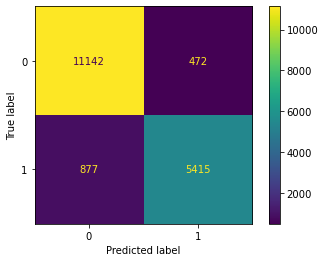

In [8]:
tree = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=74))
])
tree.fit(x_train[used_num_cols1], y_train)
train_preds = tree.predict(x_train[used_num_cols1])
test_preds = tree.predict(x_test[used_num_cols1])
train_probs = tree.predict_proba(x_train[used_num_cols1])[:,1]
test_probs = tree.predict_proba(x_test[used_num_cols1])[:,1]
    
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)
train_recall = recall_score(y_train, train_preds, zero_division=0)
test_recall = recall_score(y_test, test_preds, zero_division=0)
train_precision = precision_score(y_train, train_preds, zero_division=0)
test_precision = precision_score(y_test, test_preds, zero_division=0)
train_f1 = f1_score(y_train, train_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)
train_rocauc = roc_auc_score(y_train, train_probs)
test_rocauc = roc_auc_score(y_test, test_probs)

print(F'\nTrain Accuracy:\t\t{train_accuracy}')
print(F'Test Accuracy:\t\t{test_accuracy}')
print(F"\nTrain Recall:\t\t{train_recall}")
print(F'Test Recall:\t\t{test_recall}')
print(F"\nTrain Precision:\t{train_precision}")
print(F'Test Precision:\t\t{test_precision}')
print(F"\nTrain f1:\t\t{train_f1}")
print(F'Test f1:\t\t{test_f1}')
print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
print(F'Test ROC-AUC:\t\t{test_rocauc}')
plot_confusion_matrix(cv_rfc, x_test[used_num_cols1], y_test)

In [23]:
# tree = Pipeline(steps=[
#     ('preprocessor',preprocessor),
#     ('tree', DecisionTreeClassifier(random_state=42))
# ])

# # tree.fit(x_train[used_num_cols1], y_train)
# param_grid = {
#     "tree__max_depth" : [35, 40, 45],
#     "tree__min_samples_split" : [50, 55, 60],
# }
# cv_rfc = GridSearchCV(estimator=tree, param_grid=param_grid, cv=10, scoring="recall")
# cv_rfc.fit(x_train[used_num_cols1], y_train)

# print(cv_rfc.best_score_)

# estimator = cv_rfc.best_estimator_
# print(estimator)

# train_preds = estimator.predict(x_train[used_num_cols1])
# test_preds = estimator.predict(x_test[used_num_cols1])
# train_probs = estimator.predict_proba(x_train[used_num_cols1])[:,1]
# test_probs = estimator.predict_proba(x_test[used_num_cols1])[:,1]
    
# train_accuracy = accuracy_score(y_train, train_preds)
# test_accuracy = accuracy_score(y_test, test_preds)
# train_recall = recall_score(y_train, train_preds, zero_division=0)
# test_recall = recall_score(y_test, test_preds, zero_division=0)
# train_precision = precision_score(y_train, train_preds, zero_division=0)
# test_precision = precision_score(y_test, test_preds, zero_division=0)
# train_f1 = f1_score(y_train, train_preds, zero_division=0)
# test_f1 = f1_score(y_test, test_preds, zero_division=0)
# train_rocauc = roc_auc_score(y_train, train_probs)
# test_rocauc = roc_auc_score(y_test, test_probs)

# print(F'\nTrain Accuracy:\t\t{train_accuracy}')
# print(F'Test Accuracy:\t\t{test_accuracy}')
# print(F"\nTrain Recall:\t\t{train_recall}")
# print(F'Test Recall:\t\t{test_recall}')
# print(F"\nTrain Precision:\t{train_precision}")
# print(F'Test Precision:\t\t{test_precision}')
# print(F"\nTrain f1:\t\t{train_f1}")
# print(F'Test f1:\t\t{test_f1}')
# print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
# print(F'Test ROC-AUC:\t\t{test_rocauc}')

0.8610081798442328
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('tree',
                 DecisionTreeClassifier(max_depth=40, min_samples_split=55,
                                        random_state=42))])

Train Accuracy:		0.9469804155186536
Test Accuracy:		0.9190215570199933

Train Recall:		0.9018532325061241
Test Recall:		0.8688811188811189

Train Precision:	0.9439799331103679
Test Precision:		0.8974064346684176

Train f1:		0.9224358625197451
Test f1:		0.8829134366925064

Train ROC-AUC:		0.9897819923430724
Test ROC-AUC:		0.9401649364693574


In [15]:
# ada = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ("boost", AdaBoostClassifier(random_state = 42)
# )
# ])
# param_grid = {
#     "boost__learning_rate" : [.1],
#     "boost__n_estimators" : [1000]
# }

# gs = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5)

# gs.fit(x_train[used_num_cols1], y_train)

# print(gs.best_score_)

# estimator = gs.best_estimator_
# print(estimator)

# train_preds = estimator.predict(x_train[used_num_cols1])
# test_preds = estimator.predict(x_test[used_num_cols1])
# train_probs = estimator.predict_proba(x_train[used_num_cols1])[:,1]
# test_probs = estimator.predict_proba(x_test[used_num_cols1])[:,1]
    
# train_accuracy = accuracy_score(y_train, train_preds)
# test_accuracy = accuracy_score(y_test, test_preds)
# train_recall = recall_score(y_train, train_preds, zero_division=0)
# test_recall = recall_score(y_test, test_preds, zero_division=0)
# train_precision = precision_score(y_train, train_preds, zero_division=0)
# test_precision = precision_score(y_test, test_preds, zero_division=0)
# train_f1 = f1_score(y_train, train_preds, zero_division=0)
# test_f1 = f1_score(y_test, test_preds, zero_division=0)
# train_rocauc = roc_auc_score(y_train, train_probs)
# test_rocauc = roc_auc_score(y_test, test_probs)

# print(F'\nTrain Accuracy:\t\t{train_accuracy}')
# print(F'Test Accuracy:\t\t{test_accuracy}')
# print(F"\nTrain Recall:\t\t{train_recall}")
# print(F'Test Recall:\t\t{test_recall}')
# print(F"\nTrain Precision:\t{train_precision}")
# print(F'Test Precision:\t\t{test_precision}')
# print(F"\nTrain f1:\t\t{train_f1}")
# print(F'Test f1:\t\t{test_f1}')
# print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
# print(F'Test ROC-AUC:\t\t{test_rocauc}')

0.912335253508683
Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('boost',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=1000,
                                    random_state=42))])

Train Accuracy:		0.9131916002680766
Test Accuracy:		0.9117055735507651

Train Recall:		0.8000852060922355
Test Recall:		0.8014939605848697

Train Precision:	0.9429485972509886
Test Precision:		0.9382325581395349

Train f1:		0.865662182017228
Test f1:		0.8644895860118282

Train ROC-AUC:		0.9425563951543127
Test ROC-AUC:		0.9423966964043987
